In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

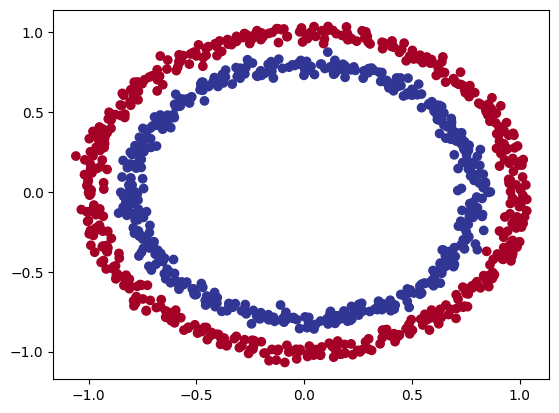

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 check Input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into reality

In [10]:
import torch
torch.__version__

'2.2.1+cu121'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [17]:
X_train.shape

torch.Size([800, 2])

In [18]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [19]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 ->  layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
device

'cpu'

In [21]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3479,  0.4679],
                      [-0.3209,  0.6693],
                      [ 0.2759,  0.4802],
                      [ 0.0683,  0.5826],
                      [ 0.1466, -0.2530]])),
             ('0.bias', tensor([-0.2143,  0.5049, -0.6135, -0.2170, -0.0532])),
             ('1.weight',
              tensor([[ 0.0798,  0.4369,  0.3578, -0.1560,  0.3151]])),
             ('1.bias', tensor([0.0698]))])

In [23]:
untrained_preds = model_0(X_test.to(device))
print(f"Lenght of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFfirst 10 labels:\n{y_test[:10]}")

Lenght of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [0.]], grad_fn=<RoundBackward0>)

Ffirst 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [24]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss functions and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific..

For example for regression you mgith want MAE or MSe ( mean absolute eorr  or Mean square error)
    
In the case of the classification you should use the binary cross Entorpy or Categorical cross Entropy!😊😊

> reminder: the loss functions measures How wrong you model predictions are🧠

### 2.1 Setup loss function and optimizer

We've setup a loss (also called a criterion or cost function) and optimizer before in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-a-loss-function-and-optimizer-in-pytorch).

But different problem types require different loss functions. 

For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer (`torch.optim.Adam()`). 

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Mutli-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these some common ones you'll see.*

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use? 

The [documentation for `torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. 

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer. 

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [25]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss  = singmoid activation function built--in 


optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3479,  0.4679],
                      [-0.3209,  0.6693],
                      [ 0.2759,  0.4802],
                      [ 0.0683,  0.5826],
                      [ 0.1466, -0.2530]])),
             ('0.bias', tensor([-0.2143,  0.5049, -0.6135, -0.2170, -0.0532])),
             ('1.weight',
              tensor([[ 0.0798,  0.4369,  0.3578, -0.1560,  0.3151]])),
             ('1.bias', tensor([0.0698]))])

In [26]:
# Calculate accuracy -  out of 100 examples, what percentage does our  model get right?

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Training the model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward Pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (backpropogation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probablities -> prediction tables

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilties by passing them to some ind of activation function ( eg. singmoid of binary classification and softmax for  multiclassification)

In [27]:
#view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2887],
        [ 0.3890],
        [-0.0486],
        [ 0.3845],
        [-0.1665]])

In [28]:
# use the sigmoid activation function on our model logits
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5717],
        [0.5960],
        [0.4879],
        [0.5950],
        [0.4585]])

For our prediction probability values, we need to perform a range-style rounding on them:

*  `y_preds_probs` >= 0.5 y=(class 1)
* `y_preds_probs`<0.5 y=(class 0)

In [29]:
device

'cpu'

In [30]:
# # find the predicted labels
# y_preds = torch.round(y_preds_probs)

# # In full
# y_preds_labels = torch.round(torch.sigmoid)

### 3.2 Building a training and testing loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 10000
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training 
    model_0.train()

    ### 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs-> pred labels

    ### 2. Calculate the loss/accuracy\
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilites as input
    #                y_train)
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_pred=y_preds, y_true=y_train)


    ### 3. Optimizer zero grad

    optimizer.zero_grad()

    ### 4. Loss Backward (back propogation)
    loss.backward()

    ### 5. Optimizer step (gradient descent)
    optimizer.step()

    ### 6. Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_preds)
    
    # Print out what's happenin'
    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc: 2f}%")



Epoch: 0 | Loss: 0.69746, Acc: 51.88% | Test loss: 0.70674 | Test acc:  48.500000%
Epoch: 10 | Loss: 0.69602, Acc: 52.12% | Test loss: 0.70411 | Test acc:  47.000000%
Epoch: 20 | Loss: 0.69510, Acc: 51.38% | Test loss: 0.70219 | Test acc:  46.500000%
Epoch: 30 | Loss: 0.69448, Acc: 51.12% | Test loss: 0.70073 | Test acc:  46.000000%
Epoch: 40 | Loss: 0.69405, Acc: 51.00% | Test loss: 0.69960 | Test acc:  46.500000%
Epoch: 50 | Loss: 0.69374, Acc: 51.12% | Test loss: 0.69871 | Test acc:  47.000000%
Epoch: 60 | Loss: 0.69352, Acc: 51.38% | Test loss: 0.69800 | Test acc:  47.000000%
Epoch: 70 | Loss: 0.69337, Acc: 50.88% | Test loss: 0.69743 | Test acc:  46.500000%
Epoch: 80 | Loss: 0.69326, Acc: 51.50% | Test loss: 0.69696 | Test acc:  47.000000%
Epoch: 90 | Loss: 0.69318, Acc: 51.75% | Test loss: 0.69658 | Test acc:  47.500000%
Epoch: 100 | Loss: 0.69312, Acc: 51.62% | Test loss: 0.69627 | Test acc:  47.000000%
Epoch: 110 | Loss: 0.69308, Acc: 51.00% | Test loss: 0.69602 | Test acc:  47

In [32]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let'smake some predictions and make them visual!

In other words, "visualize, visualzie, visualize"


In [33]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloaded helper_functions.py")
    request =  requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


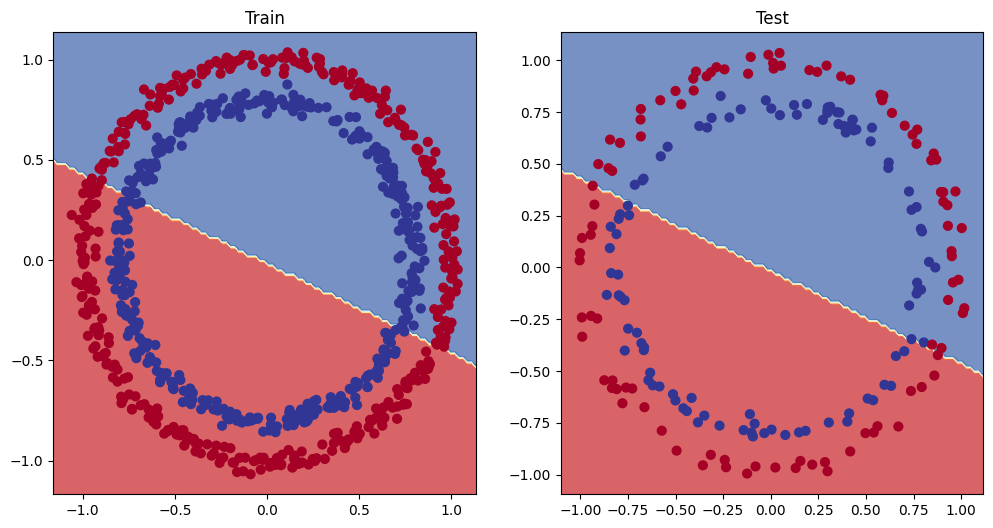

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model ( from a model prepective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit the longer
* Changing the activation functions
* change the learning rate
* change the loss function

These options are all from a model's prespective because they deal directly with model, rather than the data

And because these options are all values we ( as machine learning engineers and data scientists ) can call this **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5 -10
* increase number of layers: 2-3
* increase number of epochs: 100-1000




In [35]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)


    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [37]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Train for longer
epcohs = 1000

# Put data into target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epcohs):
    ### Training 
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropogation)
    loss.backward()

    # optimizer step( gradient descent)
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # Forward the pass
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # calculate the test loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_preds)

    if epoch%100==0:
        print(f"training_loss: {loss:.5f}, training_accuracy: {acc:.5f}% | testing_loss: {test_loss:.5f}, testing_accuracy: {test_acc:.5f}%")
        


training_loss: 0.69396, training_accuracy: 50.87500% | testing_loss: 0.69261, testing_accuracy: 51.00000%


training_loss: 0.69305, training_accuracy: 50.37500% | testing_loss: 0.69379, testing_accuracy: 48.00000%
training_loss: 0.69299, training_accuracy: 51.12500% | testing_loss: 0.69437, testing_accuracy: 46.00000%
training_loss: 0.69298, training_accuracy: 51.62500% | testing_loss: 0.69458, testing_accuracy: 45.00000%
training_loss: 0.69298, training_accuracy: 51.12500% | testing_loss: 0.69465, testing_accuracy: 46.00000%
training_loss: 0.69298, training_accuracy: 51.00000% | testing_loss: 0.69467, testing_accuracy: 46.00000%
training_loss: 0.69298, training_accuracy: 51.00000% | testing_loss: 0.69468, testing_accuracy: 46.00000%
training_loss: 0.69298, training_accuracy: 51.00000% | testing_loss: 0.69468, testing_accuracy: 46.00000%
training_loss: 0.69298, training_accuracy: 51.00000% | testing_loss: 0.69468, testing_accuracy: 46.00000%
training_loss: 0.69298, training_accuracy: 51.00000% | testing_loss: 0.69468, testing_accuracy: 46.00000%


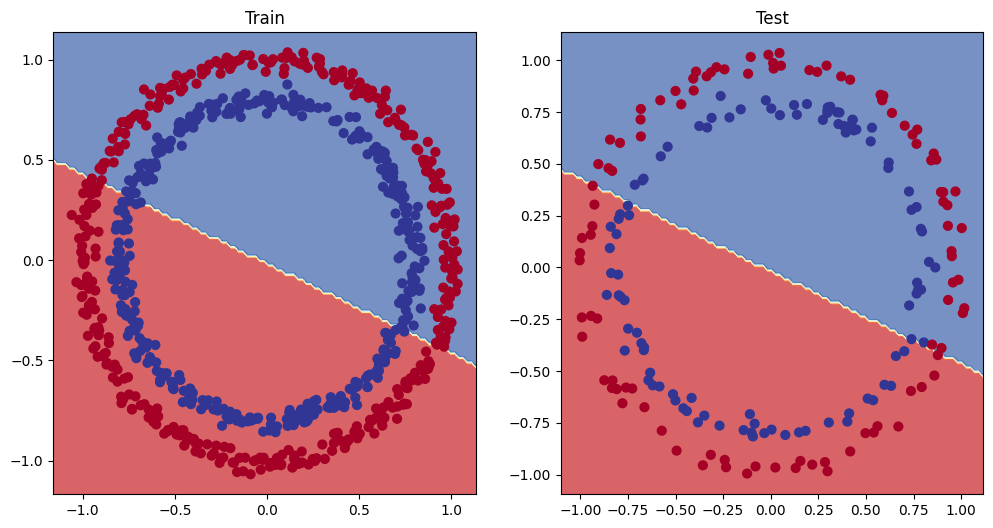

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Preparing data to see our model
One way to troubleshoot to a larger model is to check for the smaller one

In [40]:
# Create some data(same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [41]:
# Create train and splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


#check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

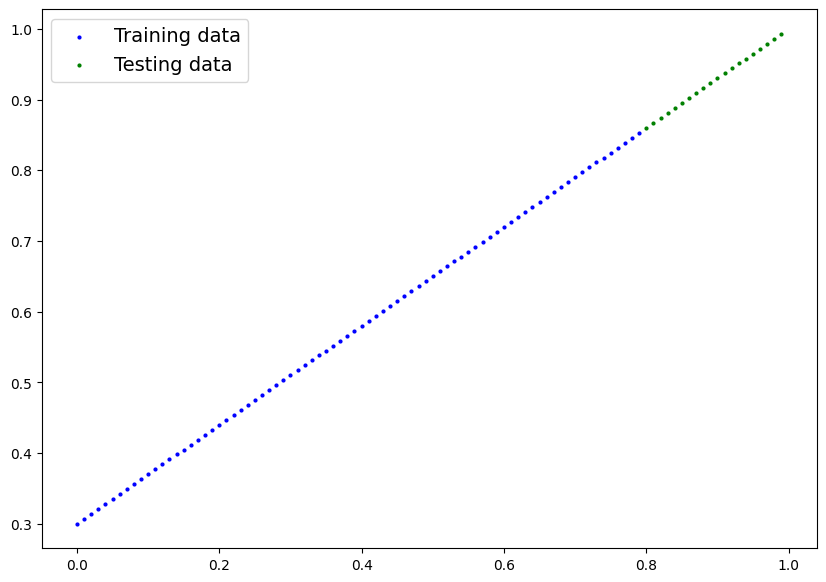

In [42]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

In [43]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2 Adjusting `model_1` to fit a straight line

In [44]:


model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [45]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7645],
                      [ 0.8300],
                      [-0.2343],
                      [ 0.9186],
                      [-0.2191],
                      [ 0.2018],
                      [-0.4869],
                      [ 0.5873],
                      [ 0.8815],
                      [-0.7336]])),
             ('0.bias',
              tensor([ 0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,  0.7709,  0.1478,
                      -0.4668,  0.2549])),
             ('1.weight',
              tensor([[-0.1457, -0.0371, -0.1284,  0.2098, -0.2496, -0.1458, -0.0893, -0.1901,
                        0.0298, -0.3123],
                      [ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0

In [46]:
# Loss and optimizer
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [47]:
# Train the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set the number of epochs
epochs = 1000

X_train_regression, X_test_regression,y_train_regression, y_test_regression = X_train_regression.to(device),X_test_regression.to(device), y_train_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### start the training mode
    model_2.train()

    # forward the data
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test_regression)
        test_loss = loss_fn(test_preds, y_test_regression)
    
    
    if epoch% 10==0:
        print(f"epoch: {epoch}| training_loss: {loss:.5f} | testing_loss: {test_loss:.5f}")

    


epoch: 0| training_loss: 0.75986 | testing_loss: 0.91103
epoch: 10| training_loss: 0.40240 | testing_loss: 0.50474
epoch: 20| training_loss: 0.06007 | testing_loss: 0.10151
epoch: 30| training_loss: 0.01559 | testing_loss: 0.03231
epoch: 40| training_loss: 0.03092 | testing_loss: 0.00111
epoch: 50| training_loss: 0.03196 | testing_loss: 0.00108
epoch: 60| training_loss: 0.03192 | testing_loss: 0.00170
epoch: 70| training_loss: 0.03081 | testing_loss: 0.00097
epoch: 80| training_loss: 0.03077 | testing_loss: 0.00150
epoch: 90| training_loss: 0.02967 | testing_loss: 0.00092
epoch: 100| training_loss: 0.02858 | testing_loss: 0.00081
epoch: 110| training_loss: 0.02962 | testing_loss: 0.00197
epoch: 120| training_loss: 0.02748 | testing_loss: 0.00091
epoch: 130| training_loss: 0.02852 | testing_loss: 0.00181
epoch: 140| training_loss: 0.02850 | testing_loss: 0.00246
epoch: 150| training_loss: 0.02744 | testing_loss: 0.00169
epoch: 160| training_loss: 0.02638 | testing_loss: 0.00123
epoch: 1

In [48]:
with torch.inference_mode():
    y_preds = model_2(X_test_regression)


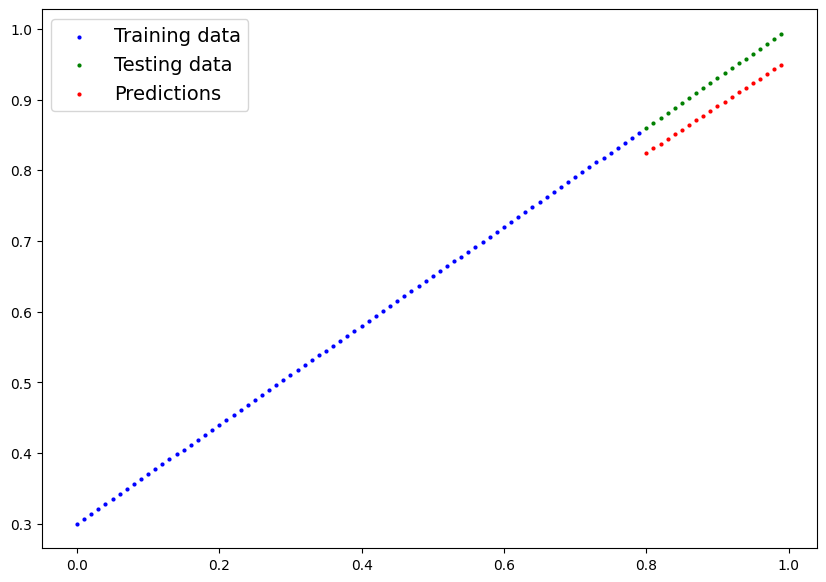

In [49]:
plot_predictions(train_data=X_train_regression.cpu().detach().numpy(),
                 train_labels=y_train_regression.cpu().detach().numpy(),
                 test_data=X_test_regression.cpu().detach().numpy(),
                 test_labels=y_test_regression.cpu().detach().numpy(),
                 predictions=y_preds.cpu().detach().numpy())

## 6. The missing piece: non-linearity

"what patterns could you draw if you were givean an infinite amount of a straight-lines?"
Or in machine learning terms, an infinite (but really it is finite) of lineas and  non-linear functions

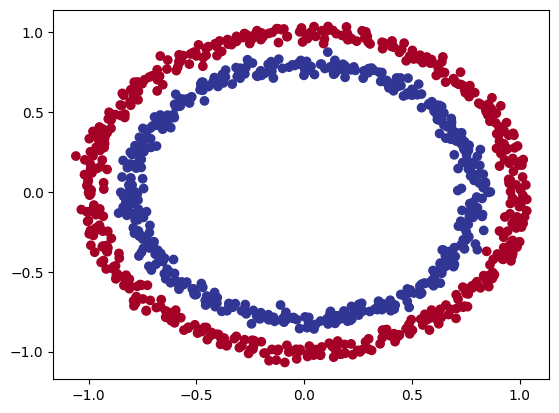

In [50]:
### 6.1 Recreating non-linear data (red and blue circles)

import matplotlib.pyplot as plt

from  sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, 
               noise=0.03,
               random_state=42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.RdYlBu)


In [51]:
# convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split

# Trun data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Split into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


### Building a model with non-linearity

In [52]:
# Build the model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU() # relu is a non-Linear activation function
    def forward(self, x):
        # where should we put our non-linear activation functions?
        return self.layer3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [53]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr = 0.1)

In [54]:
def getlen(*args):
    for i in args:
        print(len(i))

In [55]:
getlen(X_train, X_test, y_train, y_test)

800
200
800
200


### Training the model with non-linearity

In [56]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


# Loop through data
epochs = 1000
for epoch in range(epochs):
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_preds)

    # optimizer the zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    #5.step the optimizer
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(y_pred=test_preds, y_true=y_test)

    
    if epoch%10==0:
        print(f"epoch: {epoch} | training_loss: {loss:.5f}, training_acc: {acc:.5f}% | testing_loss: {test_loss:.5f}, {test_acc:.5f}%")





epoch: 0 | training_loss: 0.69295, training_acc: 50.00000% | testing_loss: 0.03951, 50.00000%
epoch: 10 | training_loss: 0.69248, training_acc: 50.50000% | testing_loss: 0.03951, 50.00000%
epoch: 20 | training_loss: 0.69225, training_acc: 59.12500% | testing_loss: 0.03951, 56.50000%
epoch: 30 | training_loss: 0.69209, training_acc: 70.25000% | testing_loss: 0.03951, 68.00000%
epoch: 40 | training_loss: 0.69195, training_acc: 68.37500% | testing_loss: 0.03951, 71.00000%
epoch: 50 | training_loss: 0.69181, training_acc: 58.25000% | testing_loss: 0.03951, 58.00000%
epoch: 60 | training_loss: 0.69168, training_acc: 54.00000% | testing_loss: 0.03951, 54.50000%
epoch: 70 | training_loss: 0.69155, training_acc: 53.12500% | testing_loss: 0.03951, 53.00000%
epoch: 80 | training_loss: 0.69141, training_acc: 52.62500% | testing_loss: 0.03951, 53.00000%
epoch: 90 | training_loss: 0.69128, training_acc: 52.75000% | testing_loss: 0.03951, 53.00000%
epoch: 100 | training_loss: 0.69115, training_acc: 

epoch: 320 | training_loss: 0.68750, training_acc: 53.12500% | testing_loss: 0.03951, 56.50000%
epoch: 330 | training_loss: 0.68727, training_acc: 52.87500% | testing_loss: 0.03951, 56.50000%
epoch: 340 | training_loss: 0.68702, training_acc: 52.87500% | testing_loss: 0.03951, 56.50000%
epoch: 350 | training_loss: 0.68676, training_acc: 52.62500% | testing_loss: 0.03951, 56.50000%
epoch: 360 | training_loss: 0.68649, training_acc: 52.87500% | testing_loss: 0.03951, 56.50000%
epoch: 370 | training_loss: 0.68619, training_acc: 52.75000% | testing_loss: 0.03951, 56.50000%
epoch: 380 | training_loss: 0.68587, training_acc: 52.62500% | testing_loss: 0.03951, 56.50000%
epoch: 390 | training_loss: 0.68552, training_acc: 52.62500% | testing_loss: 0.03951, 56.50000%
epoch: 400 | training_loss: 0.68517, training_acc: 52.75000% | testing_loss: 0.03951, 56.50000%
epoch: 410 | training_loss: 0.68481, training_acc: 52.62500% | testing_loss: 0.03951, 56.50000%
epoch: 420 | training_loss: 0.68444, tra

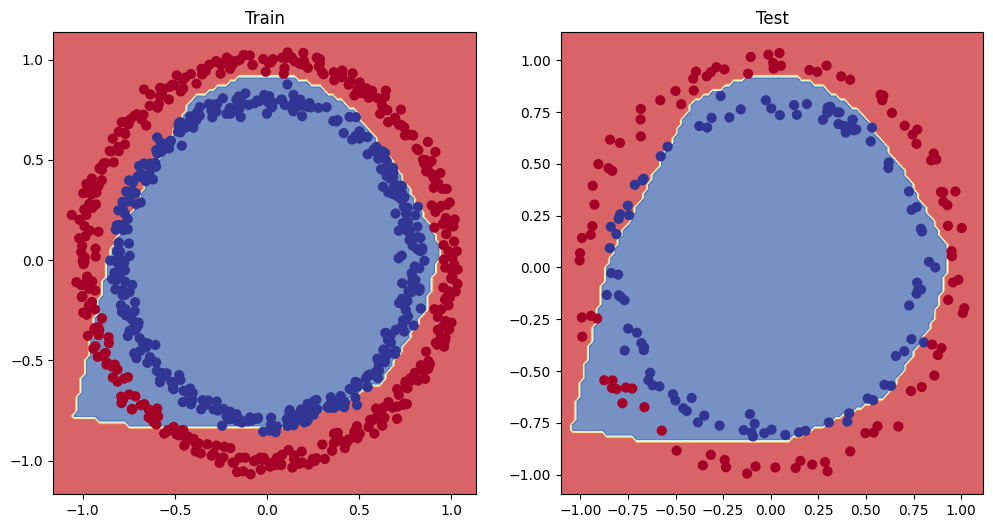

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [58]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

A.dtype

torch.float32

In [59]:
torch.int64

torch.int64

In [60]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

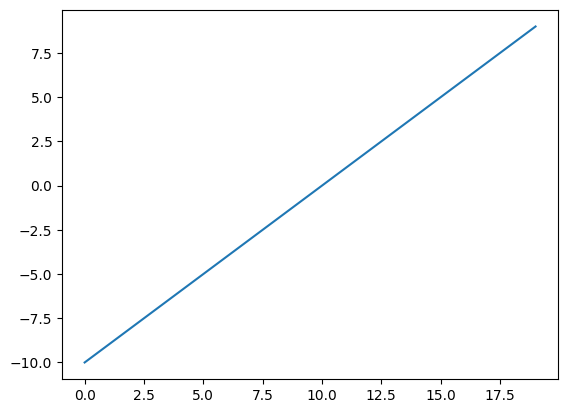

In [61]:
plt.plot(A)

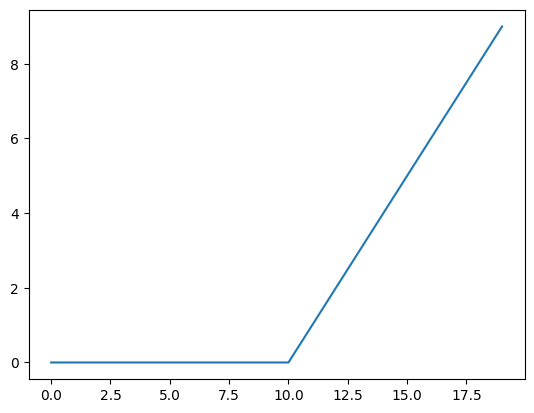

In [62]:
plt.plot(torch.relu(A))

In [63]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

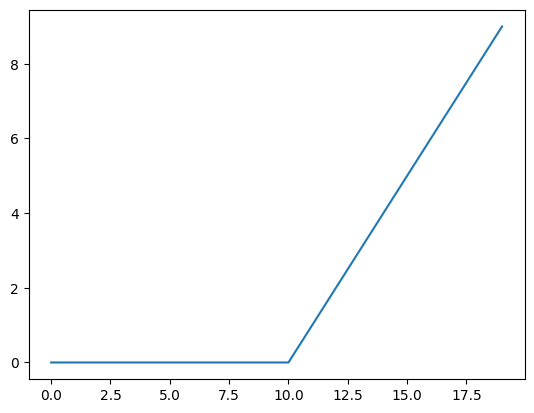

In [64]:
plt.plot(relu(A))

In [65]:
# Now let's do the same for sigmoid

def sigmoid(x):
    return 1 / ( 1 + torch.exp(-x))


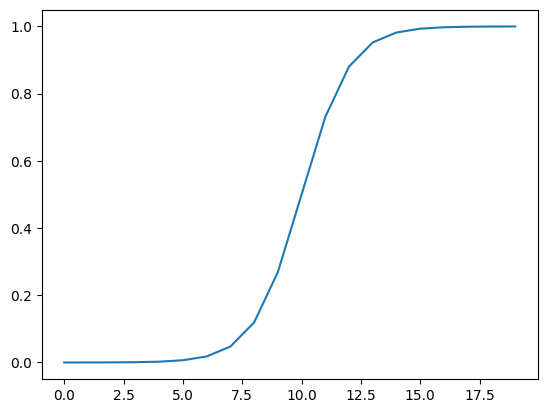

In [66]:
plt.plot(torch.sigmoid(A))

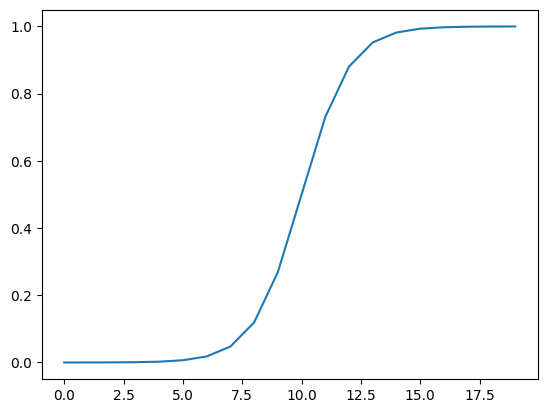

In [67]:
plt.plot(sigmoid(A))

## Putting it altogether with a multi class classification

### 8.1 Creating a toy multi-class dataset

In [68]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameter for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

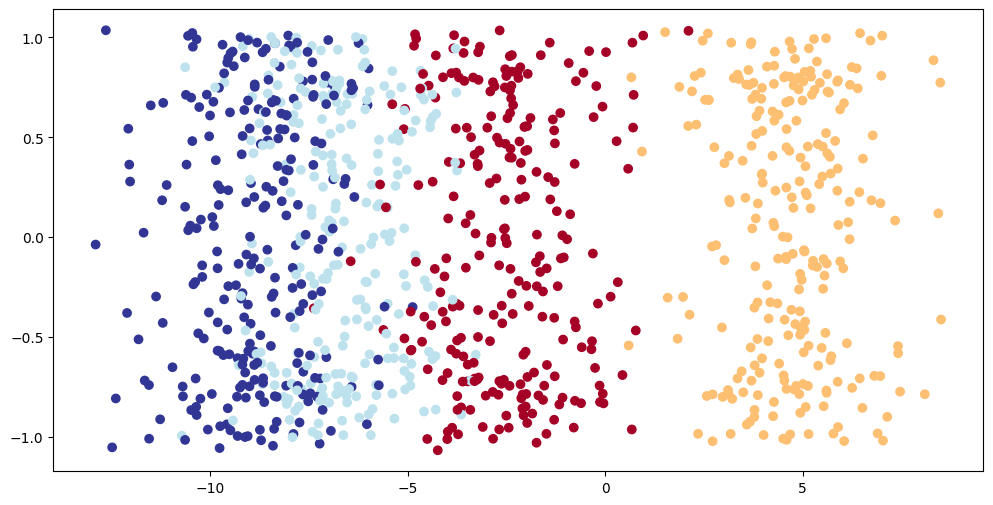

In [83]:
#1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=42)

# 2. Trun data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

# plot data()
plt.figure(figsize=(12, 6))
plt.scatter(X_blob[:, 0], X[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### Building a multi-class classification model in pytorch


In [84]:
# Create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [97]:
# Buid a multi-class classification
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Initializes the mutli-class classification
        
        Args:
            Input features(int): Number of input features to the model
            output features(int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
        
        Retures:
        
        Example:
        """

        
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Let's create an instance of Blob dataset and send it to the target device

model_4 = BlobModel(input_features=2,
                     output_features=4,
                    hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 create a loss function and and an optimizer for a multi-class classification model


In [98]:
# create a loss function for a multi-class classification

loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


In [99]:
X_test.shape

torch.Size([200, 2])

In [100]:
### 8.4 Getting prediction probablities for a multi-class Pytorch model
with torch.inference_mode():
    y_logits = model_4(X_test)
y_logits[:10]
    

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [101]:
# Convert your model's logit outputs to prediction probablities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [102]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [103]:
# convert our model's probability prediction in preduction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

### 8.5 Creating Pytorch training and testing loop for our multiclass Pytorch model


In [104]:
def fitDataInCurrentDevice(*args):
    ans = []
    for i in args:
        ans.append(i.to(device))
        type(ans[i])
    return ans

In [105]:
# Fit the model to data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the epochs 
epochs = 100

# Put data to the target devices
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


# loop through data
for epoch in range(epcohs):
    ### Training
    model_4.train()

    y_logits = model_4(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                               y_pred=test_preds)
        

    if epoch%10==0:
        print(f"epoch:{epoch} | training_loss: {loss:.5f}, training_acc:{acc:.5f} | testing_loss: {test_loss:.5f}, test_acc:{test_acc:.5f}")



epoch:0 | training_loss: 1.04324, training_acc:65.50000 | testing_loss: 0.57861, test_acc:95.50000
epoch:10 | training_loss: 0.14398, training_acc:99.12500 | testing_loss: 0.13037, test_acc:99.00000
epoch:20 | training_loss: 0.08062, training_acc:99.12500 | testing_loss: 0.07216, test_acc:99.50000
epoch:30 | training_loss: 0.05924, training_acc:99.12500 | testing_loss: 0.05133, test_acc:99.50000
epoch:40 | training_loss: 0.04892, training_acc:99.00000 | testing_loss: 0.04098, test_acc:99.50000
epoch:50 | training_loss: 0.04295, training_acc:99.00000 | testing_loss: 0.03486, test_acc:99.50000
epoch:60 | training_loss: 0.03910, training_acc:99.00000 | testing_loss: 0.03083, test_acc:99.50000
epoch:70 | training_loss: 0.03643, training_acc:99.00000 | testing_loss: 0.02799, test_acc:99.50000
epoch:80 | training_loss: 0.03448, training_acc:99.00000 | testing_loss: 0.02587, test_acc:99.50000
epoch:90 | training_loss: 0.03300, training_acc:99.12500 | testing_loss: 0.02423, test_acc:99.50000
e

epoch:300 | training_loss: 0.02564, training_acc:99.25000 | testing_loss: 0.01499, test_acc:99.50000
epoch:310 | training_loss: 0.02555, training_acc:99.25000 | testing_loss: 0.01485, test_acc:99.50000
epoch:320 | training_loss: 0.02547, training_acc:99.25000 | testing_loss: 0.01472, test_acc:99.50000
epoch:330 | training_loss: 0.02539, training_acc:99.25000 | testing_loss: 0.01460, test_acc:99.50000
epoch:340 | training_loss: 0.02531, training_acc:99.25000 | testing_loss: 0.01448, test_acc:99.50000
epoch:350 | training_loss: 0.02524, training_acc:99.25000 | testing_loss: 0.01437, test_acc:99.50000
epoch:360 | training_loss: 0.02517, training_acc:99.25000 | testing_loss: 0.01427, test_acc:99.50000
epoch:370 | training_loss: 0.02510, training_acc:99.25000 | testing_loss: 0.01417, test_acc:99.50000
epoch:380 | training_loss: 0.02504, training_acc:99.25000 | testing_loss: 0.01407, test_acc:99.50000
epoch:390 | training_loss: 0.02498, training_acc:99.25000 | testing_loss: 0.01398, test_acc

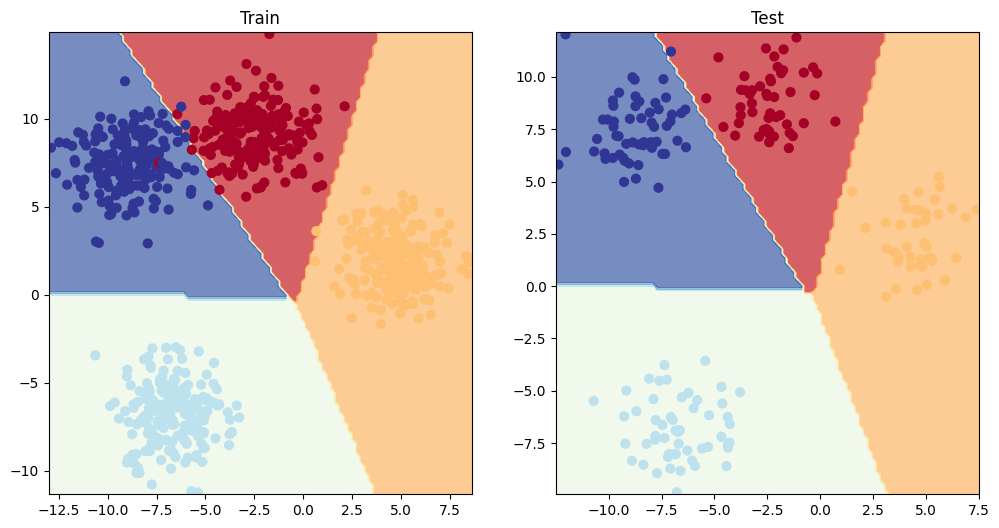

In [106]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_4, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_4, X=X_test, y=y_test)

### 9. A few more classification metrics ( to evaluate our model classification)

* Accuracy -  out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* confusion-matrix
* Classification report

see this article when to use the precision/recall: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [107]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 3.4 MB/s eta 0:00:0000:0100:01


In [109]:
from torchmetrics import Accuracy

#setup metrics
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)


#calculate accuracy
torchmetric_accuracy(test_preds, y_test)

tensor(0.9950)

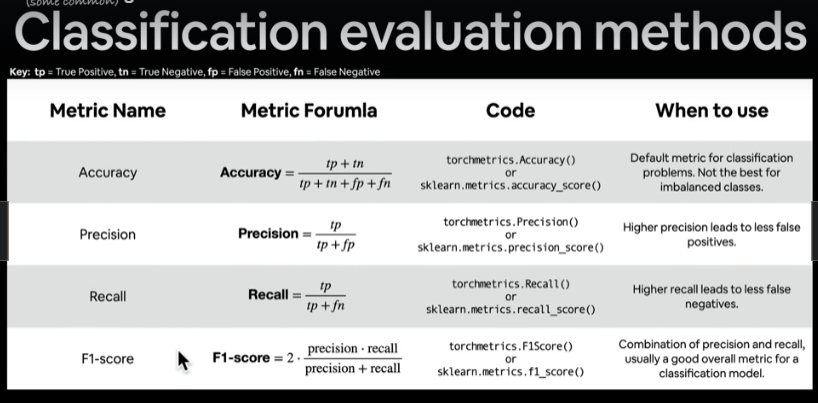